<a href="https://colab.research.google.com/github/17g01acs028/17g01acs028.github.io/blob/main/Train_YOLO_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train YOLO Models in Google Colab
**Author:** Evan Juras, [EJ Technology Consultants](https://ejtech.io)

**Last updated:** January 3, 2025

# Introduction

This notebook uses [Ultralytics](https://docs.ultralytics.com/) to train YOLO11, YOLOv8, or YOLOv5 object detection models with a custom dataset. At the end of this Colab, you'll have a custom YOLO model that you can run on your PC, phone, or edge device like the Raspberry Pi.

<p align=center>
<img src="https://s3.us-west-1.amazonaws.com/evanjuras.com/img/yolo-model-demo.gif" height="360"><br>
<i>Custom YOLO candy detection model in action!</i>
</p>

I created a YouTube video that walks through this guide step by step. I recommend following along with the video while working through this notebook.

<p align=center>
<a href="https://youtu.be/r0RspiLG260" target="_blank"><img src="https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/doc/Train_YOLO_Thumbnail2.png" height="240"><br>
<i>Click here to go to the video!</i></a>
</p>

**Important note: This notebook will be continuously updated to make sure it works with newer versions of Ultralytics and YOLO. If you see any differences between the YouTube video and this notebook, always follow the notebook!**

### Working in Colab
Colab provides a virtual machine in your browser complete with a Linux OS, filesystem, Python environment, and best of all, a free GPU. We'll install PyTorch and Ultralytics in this environment and use it to train our model. Simply click the Play button on sections of code in this notebook to execute them on the virtual machine.

### Navigation
To navigate this notebook, use the table of contents in the left sidebar to jump from section to section.





**Verify NVIDIA GPU Availability**

Make sure you're using a GPU-equipped machine by going to "Runtime" -> "Change runtime type" in the top menu bar, and then selecting one of the GPU options in the Hardware accelerator section. Click Play on the following code block to verify that the NVIDIA GPU is present and ready for training.

In [1]:
!nvidia-smi

Sun Feb 16 12:51:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#1.&nbsp;Gather and Label Training Images

Before we start training, we need to gather and label images that will be used for training the object detection model. A good starting point for a proof-of-concept model is 200 images. The training images should have random objects in the image along with the desired objects, and should have a variety of backgrounds and lighting conditions.

There are a couple options for gathering images:


*   Build a custom dataset by taking your own pictures of the objects and labeling them (this typically results in the best performance)
*   Find a pre-made dataset from sources like [Roboflow Universe](), [Kaggle](), or [Google Images V7]()


If you want to build your own dataset, there are several tools available for labeling images. One good option is [Label Studio](https://labelstud.io/?utm_source=youtube&utm_medium=video&utm_campaign=edjeelectronics), a free and open-source labeling tool that has a simple workflow while providing capabilities for more advanced features. My YouTube video that walks through this notebook (link to be added soon) shows how to label images with Label Studio.

<p align=center>
<img src="https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/doc/label-studio-example.PNG" height="380"><br>
<i>Example of a candy image labeled with Label Studio.</i>
</p>

If you used Label Studio to label and export the images, they'll be exported in a `project.zip` file that contains the following:

- An `images` folder containing the images
- A `labels` folder containing the labels in YOLO annotation format
- A `classes.txt` labelmap file that contains all the classes
- A `notes.json` file that contains info specific to Label Studio (this file can be ignored)

If you obtained your dataset from another source (like Roboflow Universe) or used another tool to label your dataset, make sure the files are organized in the same folder structure.

<p align=center>
<img src="https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/doc/zipped-data-example.png" height=""><br>
<i>Organize your data in the folders shown here. See my <a href="https://s3.us-west-1.amazonaws.com/evanjuras.com/resources/candy_data_06JAN25.zip">Candy Detection Dataset</a> for an example.</i>
</p>

Once you've got your dataset built, put into the file structure shown above, and zipped into `data.zip`, you're ready to move on to the next step.

# 2.&nbsp;Upload Image Dataset and Prepare Training Data

Next, we'll upload our dataset and prepare it for training with YOLO. We'll split the dataset into train and validation folders, and we'll automatically generate the configuration file for training the model.

## 2.1 Upload images

First, we need to upload the dataset to Colab. Here are a few options for moving the `data.zip` folder into this Colab instance.

**Option 1. Upload through Google Colab**

Upload the `data.zip` file to the Google Colab instance by clicking the "Files" icon on the left hand side of the browser, and then the "Upload to session storage" icon. Select the zip folder to upload it.

<p>
<br>
<img src="https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/doc/upload-colab-files.png" height="240">
</p>



**Option 2. Copy from Google Drive**

You can also upload your images to your personal Google Drive, mount the drive on this Colab session, and copy them over to the Colab filesystem. This option works well if you want to upload the images beforehand so you don't have to wait for them to upload each time you restart this Colab. If you have more than 50MB worth of images, I recommend using this option.

First, upload the `data.zip` file to your Google Drive, and make note of the folder you uploaded them to. Replace `MyDrive/path/to/data.zip` with the path to your zip file. (For example, I uploaded the zip file to folder called "candy-dataset1", so I would use `MyDrive/candy-dataset1/data.zip` for the path). Then, run the following block of code to mount your Google Drive to this Colab session and copy the folder to this filesystem.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/path/to/data.zip /content

**Option 3. Use my candy detection or coin detection dataset**

If you just want to test the process on a pre-made dataset, you can use one of my datasets:

*   [Candy image dataset](https://s3.us-west-1.amazonaws.com/evanjuras.com/resources/candy_data_14DEC24.zip), which contains 162 pictures of popular candies (Skittles, Snickers, etc)
*   [Coin image dataset](https://s3.us-west-1.amazonaws.com/evanjuras.com/resources/YOLO_coin_data_12DEC30.zip), which contains 750 pictures of US coins (pennies, dimes, nickels, and quarters)

Download one of the datasets by running the following code block. I'll use the candy detection dataset as the example for the rest of the notebook.

In [ ]:
# To use my one of pre-made dataset instead of your own custom dataset, download it here (control which dataset is downloaded by commenting out either line)
!wget -O /content/data.zip https://s3.us-west-1.amazonaws.com/evanjuras.com/resources/candy_data_06JAN25.zip # Candy dataset
#!wget -O /content/data.zip https://s3.us-west-1.amazonaws.com/evanjuras.com/resources/YOLO_coin_data_12DEC30.zip # Coin dataset

## 2.2 Split images into train and validation folders

At this point, whether you used Option 1, 2, or 3, you should be able to click the folder icon on the left and see your `data.zip` file in the list of files. Next, we'll unzip `data.zip` and create some folders to hold the images. Run the following code block to unzip the data.

In [8]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

Ultralytics requires a particular folder structure to store training data for models. Ultralytics requires a particular folder structure to store training data for models. The root folder is named “data”. Inside, there are two main folders:

*   **Train**: These are the actual images used to train the model. In one epoch of training, every image in the train set is passed into the neural network. The training algorithm adjusts the network weights to fit the data in the images.


*   **Validation**: These images are used to check the model's performance at the end of each training epoch.

In each of these folders is a “images” folder and a “labels” folder, which hold the image files and annotation files respectively.


I wrote a Python script that will automatically create the required folder structure and randomly move 90% of dataset to the "train" folder and 10% to the "validation" folder. Run the following code block to download and execute the scrpt.

In [9]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-02-16 13:08:38--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-02-16 13:08:38 (44.5 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 12
Number of annotation files: 12
Images moving to train: 10
Images moving to validation: 2


# 3.&nbsp;Install Requirements (Ultralytics)

Next, we'll install the Ultralytics library in this Google Colab instance. This Python library will be used to train the YOLO model.

In [10]:
!pip install ultralytics

# 4.&nbsp;Configure Training


There's one last step before we can run training: we need to create the Ultralytics training configuration YAML file. This file specifies the location of your train and validation data, and it also defines the model's classes. An example configuration file model is available [here](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/datasets/coco128.yaml).

Run the code block below to automatically generate a `data.yaml` configuration file. Make sure you have a labelmap file located at `custom_data/classes.txt`. If you used Label Studio or one of my pre-made datasets, it should already be present. If you assembled the dataset another way, you may have to manually create the `classes.txt` file (see [here](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/doc/classes.txt) for an example of how it's formatted).

In [11]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 9
names:
- date_of_issue
- district_of_birth
- dob
- fullname
- gender
- id_number
- id_serial
- photo
- place_of_issue


# 5.&nbsp;Train Model

## 5.1 Training Parameters
Now that the data is organized and the config file is created, we're ready to start training! First, there are a few important parameters to decide on. Visit my article on [Training YOLO Models Locally](https://www.ejtech.io/learn/train-yolo-models) to learn more about these parameters and how to choose them.

**Model architecture & size (`model`):**

There are several YOLO11 models sizes available to train, including `yolo11n.pt`, `yolo11s.pt`, `yolo11m.pt`, `yolo11l.pt`, and `yolo11xl.pt`. Larger models run slower but have higher accuracy, while smaller models run faster but have lower accuracy. I made a brief YouTube video that compares performance of different YOLO models on a Raspberry Pi 5 and a laptop with a RTX 4050 GPU, [check it out here to get a sense of their speed accuracy](https://youtu.be/_WKS4E9SmkA). If you aren't sure which model size to use, `yolo11s.pt` is a good starting point.

You can also train YOLOv8 or YOLOv5 models by substituting `yolo11` for `yolov8` or `yolov5`.


**Number of epochs (`epochs`)**

In machine learning, one “epoch” is one single pass through the full training dataset. Setting the number of epochs dictates how long the model will train for. The best amount of epochs to use depends on the size of the dataset and the model architecture. If your dataset has less than 200 images, a good starting point is 60 epochs. If your dataset has more than 200 images, a good starting point is 40 epochs.


**Resolution (`imgsz`)**

Resolution has a large impact on the speed and accuracy of the model: a lower resolution model will have higher speed but less accuracy. YOLO models are typically trained and inferenced at a 640x640 resolution. However, if you want your model to run faster or know you will be working with low-resolution images, try using a lower resolution like 480x480.


## 5.2 Run Training!

Run the following code block to begin training. If you want to use a different model, number of epochs, or resolution, change `model`, `epochs`, or `imgsz`.

In [23]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

The training algorithm will parse the images in the training and validation directories and then start training the model. At the end of each training epoch, the program runs the model on the validation dataset and reports the resulting mAP, precision, and recall. As training continues, the mAP should generally increase with each epoch. Training will end once it goes through the number of epochs specified by `epochs`.

> **NOTE:** Make sure to allow training to run to completion, because an optimizer runs at the end of training that strips out unneeded layers from the model.

The best trained model weights will be saved in `content/runs/detect/train/weights/best.pt`. Additional information about training is saved in the `content/runs/detect/train` folder, including a `results.png` file that shows how loss, precision, recall, and mAP progressed over each epoch.

#6.&nbsp;Test Model

The model has been trained; now it's time to test it! The commands below run the model on the images in the validation folder and then display the results for the first 10 images. This is a good way to confirm your model is working as expected. Click Play on the blocks below to see how your model performs.

In [24]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,416,283 parameters, 0 gradients, 21.3 GFLOPs

image 1/3 /content/data/validation/images/8e2ac11a-id8.png: 416x640 1 district_of_birth, 1 dob, 2 fullnames, 1 id_number, 1 id_serial, 1 photo, 1 place_of_issue, 49.8ms
image 2/3 /content/data/validation/images/b4ce2544-id10.png: 416x640 1 date_of_issue, 1 district_of_birth, 1 dob, 1 fullname, 1 gender, 1 id_number, 1 id_serial, 2 photos, 1 place_of_issue, 11.9ms
image 3/3 /content/data/validation/images/id3.png: 416x640 1 date_of_issue, 1 district_of_birth, 1 dob, 1 fullname, 1 gender, 1 id_number, 1 id_serial, 1 photo, 2 place_of_issues, 11.9ms
Speed: 3.3ms preprocess, 24.5ms inference, 50.6ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/detect/predict6
💡 Learn more at https://docs.ultralytics.com/modes/predict


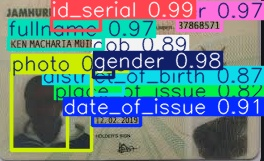

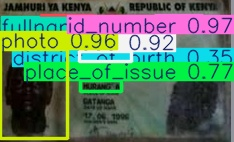

In [27]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


The model should draw a box around each object of interest in each image. If it isn't doing a good job of detecting objects, here are a few tips:

1. Double-check your dataset to make sure there are no labeling errors or conflicting examples.
2. Increase the number of epochs used for training.
3. Use a larger model size (e.g. `yolo11l.pt`).
4. Add more images to the training dataset. See my [dataset video](https://www.youtube.com/watch?v=v0ssiOY6cfg) for tips on how to capture good training images and improve accuracy.

You can also run the model on video files or other images images by uploading them to this notebook and using the above `!yolo detect predict` command, where `source` points to the location of the video file, image, or folder of images. The results will be saved in `runs/detect/predict`.

Drawing boxes on images is great, but it isn't very useful in itself. It's also not very helpful to just run this models inside a Colab notebook: it's easier if we can just run it on a local computer. Continue to the next section to see how to download your newly trained model and run it on a local device.

#7.&nbsp;Deploy Model

Now that your custom model has been trained, it's ready to be downloaded and deployed in an application! YOLO models can run on a wide variety of hardware, including PCs, embedded systems, and phones. Ultralytics makes it easy to convert the YOLO models to various formats (`tflite`, `onnx`, etc.) and deploy them in a variety of environments.

This section shows how to download the model and provides links to instructions for deploying it on your PC and edge devices like the Raspberry Pi.

## 7.1 Download YOLO Model

First, zip and download the trained model by running the code blocks below.

The code creates a folder named `my_model`, moves the model weights into it, and renames them from `best.pt` to `my_model.pt`. It also adds the training results in case you want to reference them later. It then zips the folder as `my_model.zip`.

In [28]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/train_batch50.jpg (deflated 24%)
  adding: train/labels_correlogram.jpg (deflated 53%)
  adding: train/val_batch0_pred.jpg (deflated 18%)
  adding: train/R_curve.png (deflated 9%)
  adding: train/results.csv (deflated 68%)
  adding: train/val_batch0_labels.jpg (deflated 19%)
  adding: train/events.out.tfevents.1739711369.cf3c044aa061.4903.0 (deflated 91%)
  adding: train/train_batch52.jpg (deflated 23%)
  adding: train/train_batch0.jpg (deflated 11%)
  adding: train/PR_curve.png (deflated 20%)
  adding: train/F1_curve.png (deflated 5%)
  adding: train/P_curve.png (deflated 8%)
  adding: train/labels.jpg (deflated 45%)
  adding: train/train_batch2.jpg (deflated 11%)
  adding: train/confusion_matrix_normalized.png (deflated 24%)
  adding: train/train_batch51.jpg (deflated 19%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/weights/best.pt 

In [29]:
# This takes forever for some reason, you can also just download the model from the sidebar
from google.colab import files

files.download('/content/my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 7.2 Deploy YOLO Model on Local Devices

Next, we'll take our downloaded model and run it on a local device. This section provides instructions showing how to deploy YOLO models on various devices.

I wrote a basic Python script, `yolo_detect.py`, that shows how to load a model, run inference on an image source, parse the inference results, and display boxes around each detected class in the image. The [script](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/yolo_detect.py) gives an example of how to work with Ultralytics YOLO models in Python, and it can be used as a starting point for more advanced applications.

### 7.2.1 Deploy on PC (Windows, Linux, or macOS)

The easiest way to run Ultralytics models on a PC is using Anaconda. Anaconda sets up a virtual Python environment and allows you to easily install Ultralytics and PyTorch. It automatically installs CUDA and cuDNN, which allows you to speed up model inference with your NVIDIA GPU.

> **NOTE:** My YouTube video (link to be added) shows how to deploy your model on a PC. It walks through the following steps, so watch the video if you prefer having visual instructions.

**1. Download and Install Anaconda**

Go to the Anaconda download page at https://anaconda.com/download, click the “skip registration” button, and then download the package for your OS. When it's finished downloading, run the installer and click through the installation steps. You can use the default options for installation.

**2. Set up virtual environment**

Once it's installed, run Anaconda Prompt from the Start Bar. (If you're on macOS or Linux, just open a command terminal).

Issue the following commands to create a new Python environment and activate it:

```
conda create --name yolo-env1 python=3.12 -y
conda activate yolo-env1
```

Install Ultralytics (which also installs import libraries like OpenCV-Python, Numpy, and PyTorch) by issuing the following command:

```
pip install ultralytics
```

If you have an NVIDIA GPU, you can install the GPU-enabled version of PyTorch by issuing the following command:

```
pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
```

**3. Extract downloaded model**
Take the `my_model.zip` file you downloaded in Step 7.1 and unzip it to a folder on your PC. In the Anaconda Prompt terminal, move into the unzipped folder using:

```
cd path/to/folder
```

**4. Download and run yolo_detect.py**

Download the `yolo_detect.py` script into the `my_model` folder using:

```
curl -o yolo_detect.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/yolo_detect.py
```

Alright! We're ready to run the script. To run inference with a yolov8s model on a USB camera at 1280x720 resolution, issue:

```
python yolo_detect.py --model my_model.pt --source usb0 --resolution 1280x720
```

A window will appear showing a live feed from your webcam with boxes drawn around detected objects in each frame.

You can also run the model on an video file, image, or folder of images. To see a full list of arguments for `yolo_detect.py`, issue `python yolo_detect.py --help` or see the [README file](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/README.md).




### 7.2.2 Deploy on Raspberry Pi

Keep an eye out for an article showing how to convert YOLO models to NCNN format and run them on the Raspberry Pi!

# 8.&nbsp;Conclusion

Congratulations! You've successfully trained and deployed a YOLO object detection model. 😀

Next, you can extend your application beyond just drawing boxes and counting objects. Add functionality like logging the number of objects detected over time or taking a picture when certain objects are detected. Check out some example applications at our GitHub repository: https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models

Thanks for working through this notebook, and good luck with your projects!

# Appendix: Common Errors

If you run into any errors working through this notebook, please do the following:


- Double-check that the dataset files are set up in the correct folder structure
- Make sure there are no typos or errors in your labelmap file
- Google search the error to look for solutions

If none of those help, please submit an [Issue](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/issues) on the GitHub page. In this section, I will add resolutions to common errors as they come up.